In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, EarlyStoppingCallback
from transformers import DataCollatorForSeq2Seq
from huggingface_hub import HfFolder
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments
from datasets import load_dataset
from datasets import concatenate_datasets
from transformers import T5ForConditionalGeneration, T5Tokenizer
from transformers import GenerationConfig
from random import randrange
import evaluate
import nltk
from ast import literal_eval
import numpy as np
from nltk.tokenize import sent_tokenize
from collections import Counter
nltk.download("punkt")

[nltk_data] Downloading package punkt to /home/risto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
# !pip install nltk

In [3]:
# !pip install evaluate

In [4]:
# !pip install rouge_score

In [5]:
# !pip install py7zr

In [6]:
# !pip install peft

In [7]:
# !pip install transformers --upgrade

source: https://towardsdatascience.com/how-to-adapt-a-multilingual-t5-model-for-a-single-language-b9f94f3d9c90

## model

In [4]:
model_id="google/mt5-base"

In [8]:
tokenizer = T5Tokenizer.from_pretrained(model_id)
model = T5ForConditionalGeneration.from_pretrained(model_id)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
You are using a model of type mt5 to instantiate a model of type t5. This is not supported for all configurations of models and can yield errors.


In [9]:
def msize(m):
    return sum(p.numel() for p in m.parameters())
print(msize(model.shared) / msize(model))   
print(msize(model.lm_head) / msize(model))  

0.32981729710484153
0.32981729710484153


about 42% are embeddings

## data

In [2]:
dataset_id = "TalTechNLP/LongSumEt"
dataset = load_dataset(dataset_id)

print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 8656
Test dataset size: 481


In [3]:
dataset['train']=dataset['train'].filter(lambda example, idx: example['bulletpoints'] is not None and example['text'] is not None, with_indices=True)
dataset['test'] = dataset['test'].filter(lambda example, idx: example['bulletpoints'] is not None and example['text'] is not None, with_indices=True)

In [4]:
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")

Train dataset size: 8656
Test dataset size: 481


In [5]:
train_dataset = dataset['train'].filter(lambda example, idx: example['bulletpoints'] is not None and example['text'] is not None, with_indices=True)
train_dataset

Dataset({
    features: ['text', 'long_summary', 'short_summary', 'bulletpoints', 'timestamp', 'url', 'source'],
    num_rows: 8656
})

In [6]:
test_dataset = dataset['test'].filter(lambda example, idx: example['bulletpoints'] is not None and example['text'] is not None, with_indices=True)
test_dataset

Dataset({
    features: ['text', 'long_summary', 'short_summary', 'bulletpoints', 'timestamp', 'url', 'source'],
    num_rows: 481
})

In [7]:
def format_bulletpoints(example):
    example["bulletpoints"] = ' ## '.join(literal_eval(example["bulletpoints"]))
    return example

In [8]:
train_dataset = train_dataset.map(format_bulletpoints)
test_dataset = test_dataset.map(format_bulletpoints)

## update model vocabulary

In [17]:
texts4vocab=train_dataset['text']+train_dataset['bulletpoints']
len(texts4vocab)

17312

In [18]:
cnt_et = Counter()
for text in texts4vocab:
    cnt_et.update(tokenizer.encode(text))
print(len(cnt_et), len(cnt_et)/tokenizer.vocab_size)  

63872 0.25538584566173533


In [19]:
cnt_et.most_common(20)

[(259, 1648335),
 (261, 687589),
 (260, 555966),
 (263, 300766),
 (432, 290519),
 (351, 266026),
 (265, 252862),
 (266, 215732),
 (262, 206852),
 (270, 150196),
 (383, 128058),
 (285, 121275),
 (316, 108962),
 (1055, 103119),
 (280, 101058),
 (427, 98684),
 (273, 83386),
 (264, 82562),
 (3692, 75576),
 (3242, 73647)]

In [20]:
new_tokens = set(range(1000))
for i, (k, v) in enumerate(cnt_et.items()):
    if k not in new_tokens:
        new_tokens.add(k)
for t in range(tokenizer.vocab_size - 100, tokenizer.vocab_size):
    new_tokens.add(t)
print(len(new_tokens))
kept_ids = sorted(new_tokens)

64378


In [21]:
kept_ids[-10:]

[250090,
 250091,
 250092,
 250093,
 250094,
 250095,
 250096,
 250097,
 250098,
 250099]

### update model

In [22]:
new_size = len(kept_ids)
new_emb = torch.nn.Embedding(new_size, model.shared.embedding_dim)
new_head = torch.nn.Linear(in_features=model.lm_head.in_features, out_features=new_size, bias=False)
for new_id, old_id in enumerate(kept_ids):
    new_emb.weight.data[new_id] = model.shared.weight.data[old_id]
    new_head.weight.data[new_id] = model.lm_head.weight.data[old_id]
model.shared.weight = new_emb.weight
model.lm_head.weight = new_head.weight
model.config.__dict__['vocab_size'] = new_size
model.config.__dict__['_name_or_path'] = 'mt5_et_base_bullets/mt_et_t5-base_bullets'

### update tokenizer

In [43]:
# !apt-get update 
# !apt install protobuf-compiler -y

In [24]:
! wget https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
! protoc --python_out=. sentencepiece_model.proto
import sentencepiece.sentencepiece_model_pb2 as spmp
smp = tokenizer.sp_model.serialized_model_proto()
m = spmp.ModelProto()
m.ParseFromString(smp)
print('the loaded model has pieces:', len(m.pieces))
new_pieces = [m.pieces[idx] for idx in kept_ids]
print('the new pieces:', len(new_pieces))
# replace the content of the first 30K pieces
for i, p in enumerate(new_pieces):
    m.pieces[i].piece = p.piece
    m.pieces[i].score = p.score
    m.pieces[i].type = p.type
# drop the remaining pieces
n = len(new_pieces)
for i in range(len(m.pieces) - n):
    m.pieces.pop(len(m.pieces) - 1)
print(len(m.pieces))
with open('mt5_et_base/new_sp.model', 'wb') as f:
    f.write(m.SerializeToString())
new_tokenizer = T5Tokenizer('mt5_et_base/new_sp.model', extra_ids=0)

--2024-04-16 11:29:51--  https://raw.githubusercontent.com/google/sentencepiece/master/src/sentencepiece_model.proto
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14023 (14K) [text/plain]
Saving to: ‘sentencepiece_model.proto’

sentencepiece_model 100%[===================>]  13.69K  --.-KB/s    in 0.001s  

2024-04-16 11:29:51 (14.0 MB/s) - ‘sentencepiece_model.proto’ saved [14023/14023]

the loaded model has pieces: 250100
the new pieces: 64378
64378


In [25]:
new_tokenizer.save_pretrained('mt5_et_base_bullets')
model.save_pretrained('mt5_et_base_bullets')

In [26]:
new_tokenizer('tere tulemast!')

{'input_ids': [767, 265, 4286, 23384, 309, 1], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [15]:
tokenizer = T5Tokenizer.from_pretrained('mt5_et_base_bullets')
model = T5ForConditionalGeneration.from_pretrained('mt5_et_base_bullets', max_length=512)

## prep data for training

In [44]:
max_source_length=1024

In [45]:
max_target_length=512

In [17]:
def preprocess_function(sample,padding="max_length"):
    # add prefix to the input for t5
    inputs = ["summarize: " + item for item in sample["text"]]

    # tokenize inputs
    model_inputs = tokenizer(inputs, max_length=max_source_length, padding=padding, truncation=True)

    # Tokenize targets with the `text_target` keyword argument
    labels = tokenizer(text=sample["bulletpoints"], max_length=max_target_length, padding=padding, truncation=True)

    # If we are padding here, replace all tokenizer.pad_token_id in the labels by -100 when we want to ignore
    # padding in the loss.
    if padding == "max_length":
        labels["input_ids"] = [
            [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
        ]

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=["text", "bulletpoints"])
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=["text", "bulletpoints"])

## evaluator

In [9]:
# Metric
metric = evaluate.load("rouge")

# helper function to postprocess text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(sent_tokenize(label)) for label in labels]

    return preds, labels

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    result = {k: round(v * 100, 4) for k, v in result.items()}
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    return result

In [19]:
# we want to ignore tokenizer pad token in the loss
label_pad_token_id = -100
# Data collator
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=model,
    label_pad_token_id=label_pad_token_id,
    pad_to_multiple_of=8
)

## training 

In [20]:
early_stop = EarlyStoppingCallback(3, 0.0)

In [22]:
# Hugging Face repository id
repository_id = f"{model_id.split('/')[1]}-{dataset_id}"#for some reason this was not working

# Define training args
training_args = Seq2SeqTrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    # gradient_accumulation_steps=4,
    predict_with_generate=True,
    fp16=False, # Overflows with fp16
    learning_rate=5e-5,
    num_train_epochs=20,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_strategy="steps",
    logging_steps=500,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    # push to hub parameters
    report_to="tensorboard",
    push_to_hub=False,
    hub_strategy="every_save",
    hub_model_id=repository_id,
    hub_token=HfFolder.get_token(),
    # generation_max_length=40
)

# Create Trainer instance
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stop]
)

/home/risto/.local/lib/python3.9/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [ ]:
# Start training
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
1,3.010900,2.392708,20.597400,5.990300,17.838400,17.870100,53.461538
2,2.674500,2.317516,22.599000,6.908400,19.647700,19.667700,52.255717
3,2.522900,2.267915,23.778400,7.322300,20.292800,20.299700,52.812890
4,2.349600,2.256726,24.511500,7.921200,20.934200,20.956300,51.964657
5,2.245900,2.232470,24.943300,7.760100,21.024400,21.031500,51.166320
6,2.131000,2.227765,25.106400,7.754000,21.417900,21.444300,52.076923


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



## calculate metrics

In [16]:
model_id='mt5-base-TalTechNLP/LongSumEt/checkpoint-38952/'
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

In [17]:
model=model.to('cuda')

In [24]:
def calc_texts_labels_metrics(texts, summaries, model, tokenizer, max_input_length=1024, max_output_length=512, batch_size = 10):
    true_labels=tokenizer(
        summaries, return_tensors="pt",padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids.cpu()
    input_ids = tokenizer(
        texts, return_tensors="pt", padding="max_length", truncation=True, max_length=max_input_length
    ).input_ids  
    
    predictions = []
    for i in range(0, input_ids.size(0), batch_size):
        batch_input_ids = input_ids[i:i + batch_size].to('cuda')
        batch_outputs = model.generate(input_ids=batch_input_ids, max_length=max_output_length)
        predictions.extend(batch_outputs.cpu().detach().numpy())
    max_length = max(len(p) for p in predictions)
    padded_predictions = [np.pad(p, (0, max_length - len(p)), mode='constant') for p in predictions]
    outputs = torch.tensor(padded_predictions)
    eval_preds = (outputs, true_labels.cpu())
    metrics = compute_metrics(eval_preds)
    return metrics

In [31]:
train_dataset

Dataset({
    features: ['text', 'long_summary', 'short_summary', 'bulletpoints', 'timestamp', 'url', 'source'],
    num_rows: 8656
})

In [32]:
eval_metrics=calc_texts_labels_metrics(test_dataset['text'], test_dataset['bulletpoints'], model, tokenizer)
eval_metrics

{'rouge1': 26.0263,
 'rouge2': 8.3355,
 'rougeL': 22.0547,
 'rougeLsum': 22.0598,
 'gen_len': 52.32016632016632}

## example usage

In [33]:
def summarize(text, model, tokenizer, max_input_length=1024, max_new_tokens=512):
    input_ids = tokenizer(
         text, return_tensors="pt",
        max_length=max_input_length
    ).input_ids  # Batch size 1
    outputs = model.generate(input_ids=input_ids.to('cuda'), max_new_tokens=max_new_tokens)
    print(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [34]:
summarize(test_dataset[0]['text'], model, tokenizer)

Hendrik Kaljujärve muusikaline kujundus ## Debüüt "Ise-organiseeruv süsteem" NO99 teatris ## Masinate ja helide eristamine ## Muusikaline kujundus lavastusele ## Muusikaline kujundus lavastusele


In [37]:
summarize("studies have shown that owning a dog is good for you", model, tokenizer)

a dog is a good pet to us ## owning a dog is a good for You


In [35]:
summarize(test_dataset[1]['text'], model, tokenizer)

Arendusdirektori ametikoha konkursitingimused ## Koostöö kolleegidega ja koostöö kunstnikkonnaga ## Kumu avamine ja Euroopa uuendusprogrammid ## Kunstivaldkonna arendamine ja nüüdiskunsti tähtsus ## Kunstivaldkonna kvaliteedi ja kvaliteedi parandamine


In [36]:
summarize(test_dataset[2]['text'], model, tokenizer)

kõrgharitud tööjõu ühiskondlik kasu ## kõrgharidusega lõpetajate kõrge töötus ## maksumaksja raha kulukus hariduse rahastamisele ## kutsehariduse tähtsus tööturul ## vajadus ühiskondliku toetuse järele


In [38]:
test_dataset[2]['bulletpoints']

'kõrgharidusega töötajate olulisus ## väike töötus kõrgkoolilõpetajate seas ## enamik töötab haridusele vastaval ametikohal ## kutsehariduse ja kõrghariduse piiride ähmastumine ## vajadus haridussüsteemi optimeerimise järele'

In [39]:
input_text="""Veel veebruaris oli Soome kõige populaarsem partei Koonderakond, kuid kaotas märtsis selle tiitli SDP-le. Märtsis langes peaministripartei  toetus ühe protsendi võrra ning Koonderakonna toetus on nüüd 20,6 protsenti.
SDP suurendas toetust naiste ja noorte hulgas. Märtsis tõusis SDP toetus 1,9 protsenti ning erakonna toetus on nüüd 21,7 protsenti. 
Koonderakonna kannul on Põlissoomlased, rahandusminister Riikka Purra kodupartei toetus on 17,4 protsenti."""
summarize(input_text, model, tokenizer)

Koonderakond kaotas tiitli SDP-le ## SDP kaotas tiitli tiitli tõusule ## Koonderakond kaotas tiitli tiitli tõusule ## Põlissoomlased ja Põlissoomlased toetused ## Põlissoomlased ja Põlissoomlased toetused


In [40]:
summarize(test_dataset[3]['text'], model, tokenizer)

Tallinna Pimedate Ööde filmifestivalil ## Allegooriliste eneseotsingute triloogia ## Kunsti ja kultuurimüüdi edasiarendus ## Huumori ja inimlikkuse tähtsus ## Pimedate Ööde filmifestivali eesmärgid


In [42]:
test_dataset[3]['text']

'Valgusetooja ja kolm lugu paradiisist — Sirp\nGust van der Berghe: "Filmi tehes tuleb igal hetkel teha esteetilisi valikuid."\n"Kui ma magama jään, siis on see tule pärast. Ära isiklikult võta," viitab Gust van der Berghe kamina suunas. Tuli ja valgus on alati tähtsal kohal selle prillidega vahetu ja tagasihoidliku olemisega mehe filmides. Teda vaadates on raske uskuda, et selles inimeses võiks olla impulss teha nii julgeid ja intuitiivseid teoseid. Gust van der Berghe on Tallinnas Pimedate Ööde filmifestivalil esindamas oma uut mängufilmi "Lutsifer" ("Lucifer", 2014), mis on kindlasti üks selle aasta tähelepanuväärsemaid. "Lutsifer" võtab kokku allegooriliste eneseotsingute triloogia, mis mõjub oma siiruses täiesti anakronistlikuna. Esmafilmis "Flandria Jeesuslapsuke" ("En waar de sterre bleef stille staan", 2010) on ta pannud Jeesuslapse sünni loos kolme kuningat mängima Downi sündroomiga lapsed, teises filmis "Sinilind" ("Blue Bird", 2012) on ta lavastanud Maurice Maeterlincki muin

In [41]:
test_dataset[3]['bulletpoints']

'Gust van der Berghe - Belgia filmirežissöör ## Allegooriline triloogia - "Lutsifer" lõpetab sarja ## Esteetilised ja intuitiivsed valikud ## Maagia ja imelisuse säilitamine filmis ## Uuenduslik levitamisviis - tasuta linastused'

## visualize logs

In [24]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing import event_accumulator

# Path to your TensorBoard log files
log_path = 'mt5-base-TalTechNLP/LongSumEt/logs/events.out.tfevents.1713270009.2ca00bef5a11.196474.0'


In [26]:
def load_tensorboard_data(event_file_path):
    # Initialize an EventAccumulator with size_guidance for auto loading of all data
    ea = event_accumulator.EventAccumulator(event_file_path,
        size_guidance={
            event_accumulator.SCALARS: 0,
            event_accumulator.IMAGES: 0,
            event_accumulator.AUDIO: 0,
            event_accumulator.HISTOGRAMS: 0,
            event_accumulator.TENSORS: 0,
        })

    # Load the data
    ea.Reload()

    # Data extraction examples
    data = {}

    # Extract scalars to a DataFrame
    for tag in ea.Tags()['scalars']:
        events = ea.Scalars(tag)
        data[tag] = pd.DataFrame([(e.step, e.value) for e in events], columns=['Step', tag])

    # Extend this part to handle histograms, images, etc., as needed

    return data

data = load_tensorboard_data(log_path)
# Example to print the available scalar tags and their first few values
for tag, df in data.items():
    print(f"Data for tag: {tag}")
    # print(df.head())
    
df

Data for tag: train/loss
Data for tag: train/learning_rate
Data for tag: train/epoch
Data for tag: eval/loss
Data for tag: eval/rouge1
Data for tag: eval/rouge2
Data for tag: eval/rougeL
Data for tag: eval/rougeLsum
Data for tag: eval/gen_len
Data for tag: eval/runtime
Data for tag: eval/samples_per_second
Data for tag: eval/steps_per_second
Data for tag: train/train_runtime
Data for tag: train/train_samples_per_second
Data for tag: train/train_steps_per_second
Data for tag: train/total_flos
Data for tag: train/train_loss


,Step,train/train_loss
0,38952,2.3691


<AxesSubplot:>

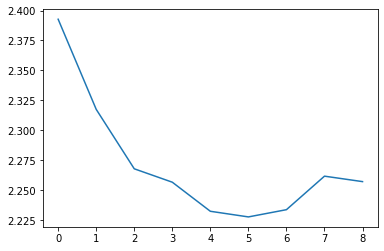

In [27]:
data['eval/loss']['eval/loss'].plot()

<AxesSubplot:>

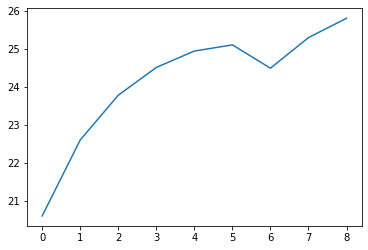

In [28]:
data['eval/rouge1']['eval/rouge1'].plot()

In [29]:
data['eval/rouge1']['eval/rouge1'].max()

25.808300018310547

<AxesSubplot:>

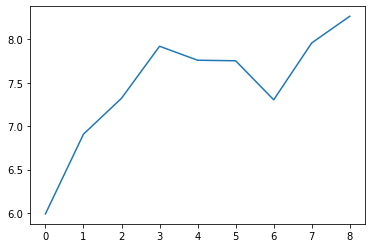

In [30]:
data['eval/rouge2']['eval/rouge2'].plot()